
# 03 – GAN-Based Anomaly Detection

**Module:** Anomaly & Fraud Detection  
**Folder:** Ensemble and Advanced Methods

This notebook demonstrates using **Generative Adversarial Networks (GANs)** for semi-supervised anomaly detection.


## Objective

Build a workflow that:
- Trains a GAN to model normal data distribution
- Uses generator-discriminator reconstruction and scoring for anomaly detection
- Flags rare-event anomalies
- Integrates into production pipelines


## Imports and Setup



In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

np.random.seed(2010)

## Simulated Dataset

In [16]:
data_normal = np.random.normal(0, 1, size=(1000, 10))
data_anomalies = np.random.normal(5, 1, size=(10, 10))
data = np.vstack([data_normal, data_anomalies])
df = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(data.shape[1])])

## Build GAN

In [19]:
latent_dim = 5
input_dim = data.shape[1]

In [21]:
# Generator
generator = Sequential([
    Dense(16, activation='relu', input_dim=latent_dim),
    Dense(input_dim, activation='linear')
])

C:\Users\pantu\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Discriminator
discriminator = Sequential([
    Dense(16, activation='relu', input_dim=input_dim),
    Dense(1, activation='sigmoid')
])
discriminator.compile(optimizer=Adam(0.001), loss='binary_crossentropy')

C:\Users\pantu\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# GAN (generator + discriminator)
discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_data = generator(z)
d_output = discriminator(generated_data)
from tensorflow.keras.models import Model as KModel
gan = KModel(z, d_output)
gan.compile(optimizer=Adam(0.001), loss='binary_crossentropy')

## Train GAN (Simplified)

In [39]:
import tensorflow.keras.backend as K

epochs = 1000
batch_size = 32

In [41]:
# Labels for discriminator
y_real = np.ones((batch_size, 1))
y_fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, data_normal.shape[0], batch_size)
    real_batch = data_normal[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_batch = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_batch, y_real)
    d_loss_fake = discriminator.train_on_batch(fake_batch, y_fake)

    # Train generator via GAN
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, y_real)

C:\Users\pantu\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


## Compute Anomaly Scores

In [51]:
noise = np.random.normal(0, 1, (data.shape[0], latent_dim))
generated_data = generator.predict(noise, verbose=0)
df['gan_score'] = discriminator.predict(data, verbose=0)
df['anomaly_flag'] = (df['gan_score'] < 0.5).astype(int)

## Summary

In [53]:
print(df['anomaly_flag'].value_counts())

anomaly_flag
0    566
1    444
Name: count, dtype: int64


## Visualization

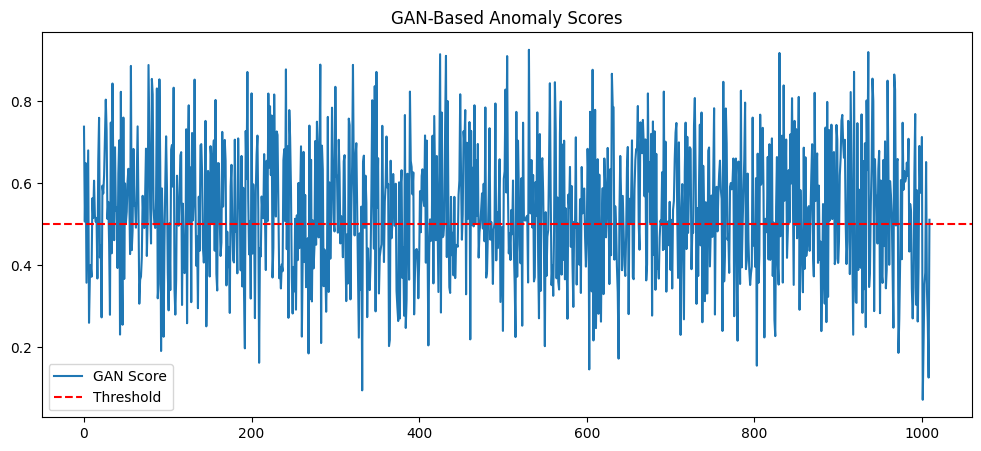

In [56]:
plt.figure(figsize=(12,5))
plt.plot(df['gan_score'], label='GAN Score')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('GAN-Based Anomaly Scores')
plt.show()


## Integration Notes

- GAN models normal data distribution  
- Discriminator output provides anomaly score  
- Semi-supervised approach works for rare-event detection  
- Can be integrated into ensemble anomaly detection pipelines


## Production Checklist

✔ Train on normal data  
✔ Use discriminator output as anomaly score  
✔ Set threshold based on desired sensitivity  
✔ Integrate anomaly flags into monitoring/alerting system


## Key Takeaways

- GAN-based detection captures complex distributions  
- Useful for rare-event or semi-supervised scenarios  
- Anomaly scores are interpretable and thresholdable  
- Requires careful training to avoid mode collapse


## Next Steps

- Combine GAN scores with VAE and classical detectors  
- Monitor anomaly score drift  
- Deploy in production pipelines for real-time anomaly detection